## Monte Carlo integration

The integral to solve is $$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

One possibility is to use a uniform distribution. So, consider $p(x)=\frac{1}{x_{max}-0}$ so that $$ x_{max} \times \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right)\,\frac{dx}{x_{max}}$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def integrand(x, sigma):
    return x**3 * np.exp(-x**2 / (2 * sigma**2))

def monte_carlo_integration_infinite(f, sigma, L, n_samples=100000):
    # Sample points uniformly in [0, L]
    x_random = np.random.uniform(0, L, n_samples)
    
    # Evaluate the function at these points
    f_values = f(x_random, sigma)
    
    # Average value of the function
    avg_f = np.mean(f_values)
    
    # Estimate the integral
    integral_estimate = L * avg_f
    
    return integral_estimate

The exact value of the integral is given by:

In [39]:
sigma = 3
exact_value = 2 * sigma**4
print(f"Exact integral: {exact_value:.6f}")

Exact integral: 162.000000


Compute the value of the integral for different $n_{samples}$ to check convergence to the expected value

In [40]:
# Different sample sizes to test
L = 6 * sigma  # upper bound to approximate infinity
sample_sizes = np.logspace(0, 6, num=50, dtype=int)  # from 1 to 1,000,000 samples

errors = []
estimates = []

for n in sample_sizes:
    estimate = monte_carlo_integration_infinite(integrand, sigma, L, n)
    error = abs(estimate - exact_value)
    errors.append(error)
    estimates.append(estimate)
    print(f"\nSamples: {n}, Estimate: {estimate:.6f}, Error: {error:.6f}")
    print(f"Estimated integral: {estimate:.6f}")
    print(f"Relative error: {abs(estimate - exact_value)/exact_value:.6f}")


Samples: 1, Estimate: 10.409686, Error: 151.590314
Estimated integral: 10.409686
Relative error: 0.935743

Samples: 1, Estimate: 559.935708, Error: 397.935708
Estimated integral: 559.935708
Relative error: 2.456393

Samples: 1, Estimate: 538.188125, Error: 376.188125
Estimated integral: 538.188125
Relative error: 2.322149

Samples: 2, Estimate: 499.430923, Error: 337.430923
Estimated integral: 499.430923
Relative error: 2.082907

Samples: 3, Estimate: 345.887429, Error: 183.887429
Estimated integral: 345.887429
Relative error: 1.135108

Samples: 4, Estimate: 211.078926, Error: 49.078926
Estimated integral: 211.078926
Relative error: 0.302956

Samples: 5, Estimate: 297.340479, Error: 135.340479
Estimated integral: 297.340479
Relative error: 0.835435

Samples: 7, Estimate: 219.175566, Error: 57.175566
Estimated integral: 219.175566
Relative error: 0.352936

Samples: 9, Estimate: 149.221151, Error: 12.778849
Estimated integral: 149.221151
Relative error: 0.078882

Samples: 12, Estimate: 

Let's put it into a graph

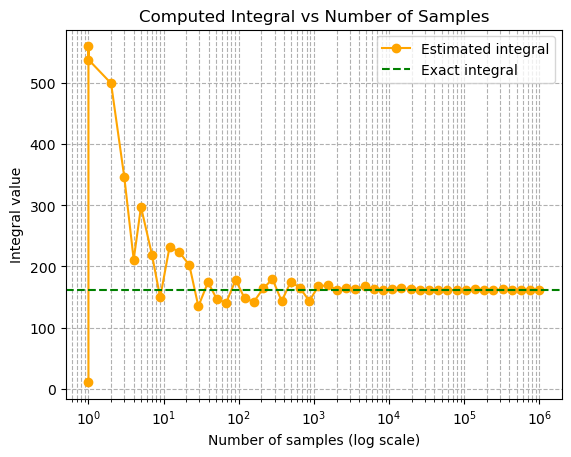

In [41]:
# Plot 1: Computed Value vs Number of Samples
plt.plot(sample_sizes, estimates, marker='o', linestyle='-', color='orange', label='Estimated integral')
plt.axhline(y=exact_value, color='green', linestyle='--', label='Exact integral')
plt.xscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('Integral value')
plt.title('Computed Integral vs Number of Samples')
plt.legend()
plt.grid(True, which="both", ls="--")

Let's now show the errors

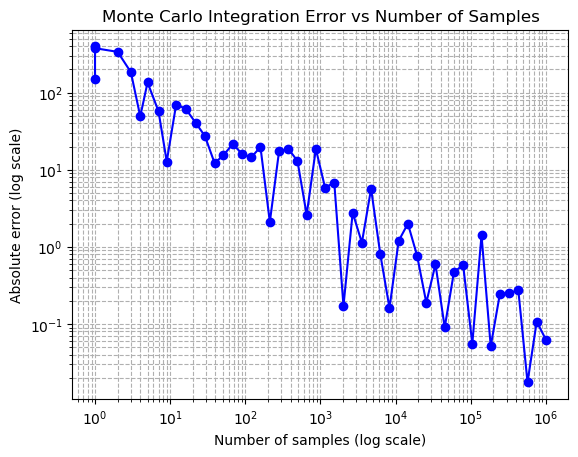

In [42]:
plt.loglog(sample_sizes, errors, marker='o', linestyle='-', color='b')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('Absolute error (log scale)')
plt.title('Monte Carlo Integration Error vs Number of Samples')
plt.grid(True, which="both", ls="--")

Seems linear in the log-log scale. Let's fit it with a simple fit

In [43]:
# Perform linear fit on log-log data for errors
log_samples = np.log10(sample_sizes)
log_errors = np.log10(errors)
coefficients = np.polyfit(log_samples, log_errors, 1)  # degree 1 polynomial fit
poly = np.poly1d(coefficients)

# Generate fitted values for plotting trend line
log_errors_fit = poly(log_samples)
errors_fit = 10**log_errors_fit

print(f"\nFitting equation (log-log scale): log10(error) = {coefficients[0]:.4f} * log10(n_samples) + {coefficients[1]:.4f}")
print(f"Equivalent power-law: error = {10**coefficients[1]:.4e} * n^{coefficients[0]:.4f}")



Fitting equation (log-log scale): log10(error) = -0.6000 * log10(n_samples) + 2.3772
Equivalent power-law: error = 2.3835e+02 * n^-0.6000


The error decrease as $1/\sqrt N$ as we would expect from the uncertainty on the mean since for each point I'm taking the average over a certain number of samples

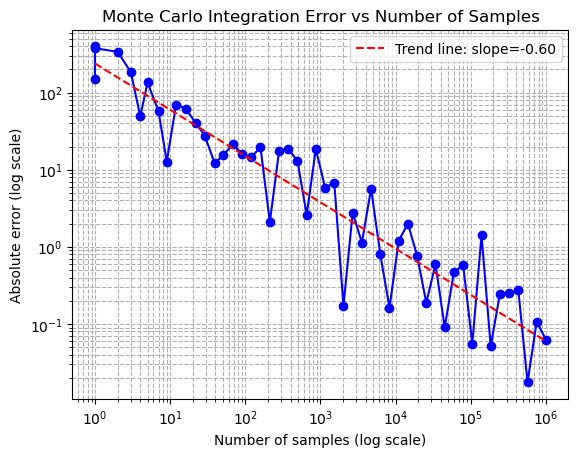

In [44]:
plt.loglog(sample_sizes, errors, marker='o', linestyle='-', color='b')
plt.loglog(sample_sizes, errors_fit, linestyle='--', color='red', label=f'Trend line: slope={coefficients[0]:.2f}')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('Absolute error (log scale)')
plt.title('Monte Carlo Integration Error vs Number of Samples')
plt.legend()
plt.grid(True, which="both", ls="--")

Now repeat the integration over $n_{iterations}$ and put into a histogram the distribution of the results of the integration. The distribution appears to be Gaussian. Take a fit using the mean value of the distribution as $\mu$ and the standard deviation of the distribution as $\sigma$

In [45]:
def analyze_monte_carlo_distribution_subplot(f, sigma, L, n_samples_list, exact_value, n_iterations=10000):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, n_samples in enumerate(n_samples_list):
        results = []
        for _ in range(n_iterations):
            estimate = monte_carlo_integration_infinite(f, sigma, L, n_samples)
            results.append(estimate)
        results = np.array(results)

        mean_estimate = np.mean(results)
        std_estimate = np.std(results)

        print(f"n_samples={n_samples}: Mean={mean_estimate:.6f}, Std={std_estimate:.6f}")

        ax = axes[i]
        count, bins, ignored = ax.hist(results, bins=30, density=True,
                                      color='skyblue', edgecolor='black',
                                      alpha=0.7, label='Monte Carlo estimates')

        dist = norm(mean_estimate, std_estimate)
        x = np.linspace(min(results), max(results), 1000)
        ax.plot(x, dist.pdf(x), 'r-', lw=2, label='Normal distribution fit')

        ax.axvline(x=exact_value, color='red', linestyle='--', label='Exact value')
        ax.axvline(x=mean_estimate, color='green', linestyle='-', label='Mean estimate')

        ax.set_title(f'n_samples = {n_samples}\nMean = {mean_estimate:.4f}, Std = {std_estimate:.4f}')
        ax.set_xlabel('Integral estimate')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, ls='--', alpha=0.6)

    plt.suptitle(f'Distribution of Monte Carlo Estimates for Different Sample Sizes\n(iterations={n_iterations})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

n_samples=1: Mean=160.168944, Std=197.153592
n_samples=2: Mean=159.895377, Std=139.061448
n_samples=5: Mean=161.976622, Std=88.438065
n_samples=1000: Mean=162.051750, Std=6.263501


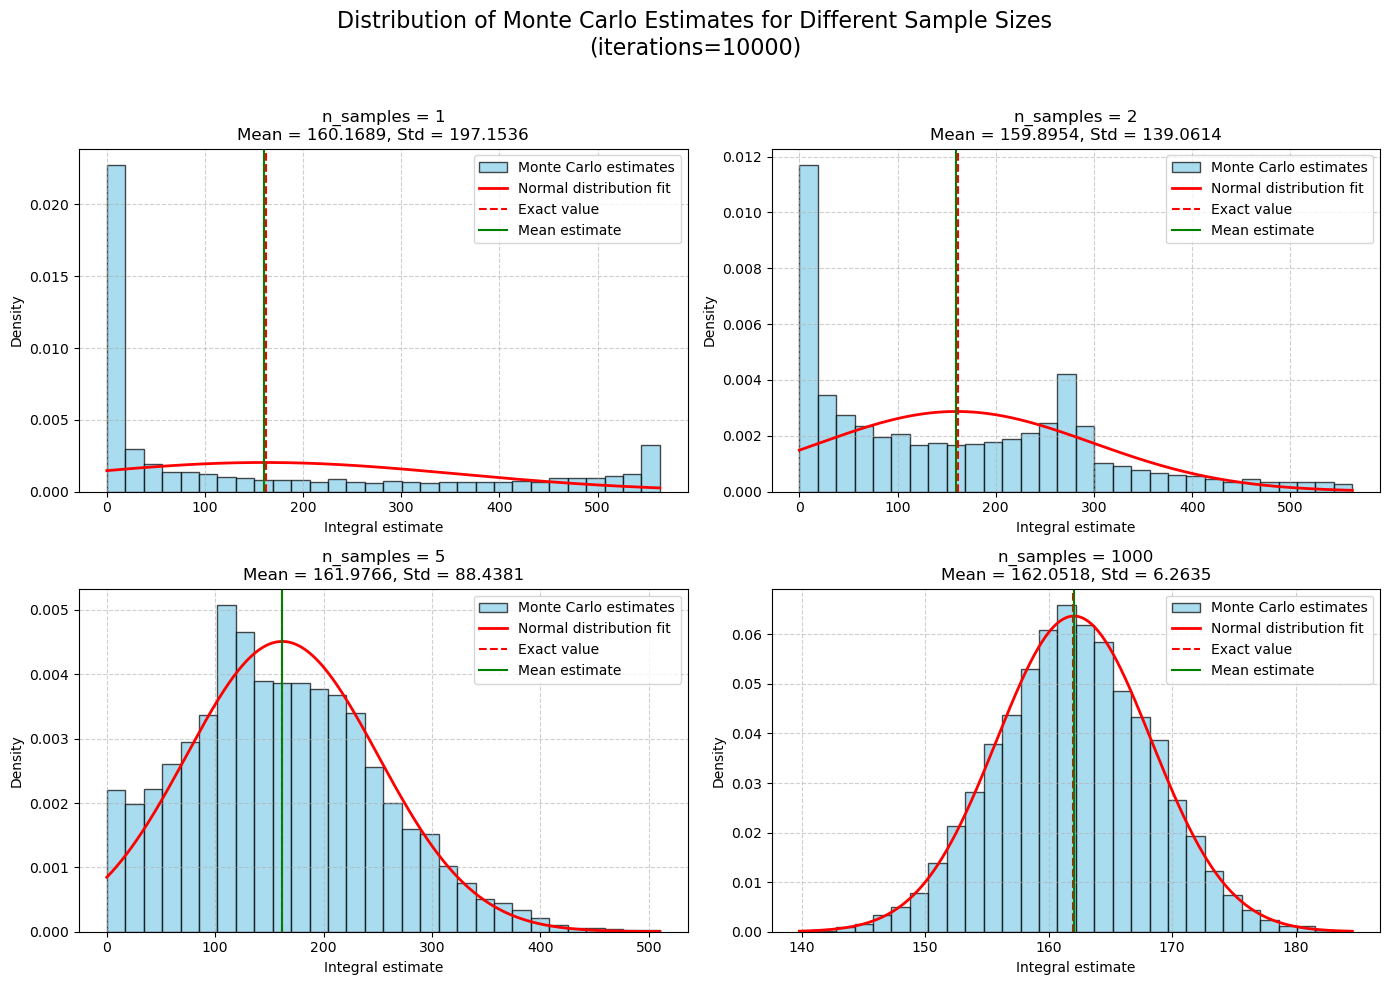

In [46]:
# Select 4 sample sizes from your sample_sizes array or define manually
sample_sizes = [1, 2, 5, 1000]

# Run the subplot analysis
analyze_monte_carlo_distribution_subplot(integrand, sigma, L, sample_sizes, exact_value)


## Horse kicks

Import the data and normalize the distribution so that is represents a probability

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np

data = {
    'Number of deaths': [0, 1, 2, 3, 4],
    'Number of groups': [109, 65, 22, 3, 1]
}

df = pd.DataFrame(data)

total_groups = df['Number of groups'].sum()
df['Probability'] = df['Number of groups'] / total_groups
x = df['Number of deaths']


Plot the distribution

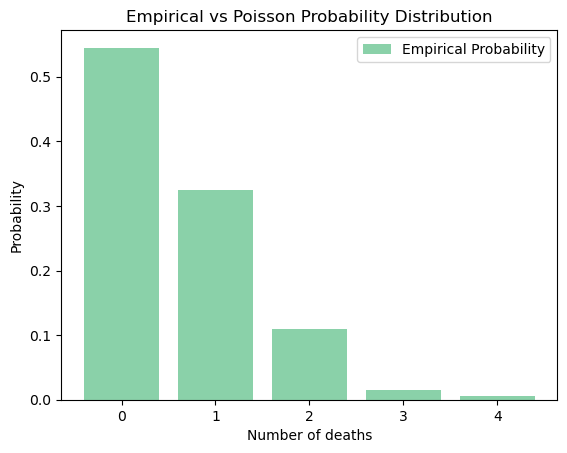

In [50]:
plt.bar(x, df['Probability'], color='mediumseagreen', alpha=0.6, label='Empirical Probability')
plt.xlabel('Number of deaths')
plt.ylabel('Probability')
plt.title('Empirical vs Poisson Probability Distribution')
plt.xticks(x)
plt.legend()
plt.show()

Compute the $\mu$ parameter for the Poissonian distribution as the average number of deaths weighted on the groups

In [51]:
mu = np.average(df['Number of deaths'],weights=df['Number of groups'])#np.sum(df['Number of deaths'] * df['Probability'])
print(f"Estimated lambda (mean number of deaths): {mu:.3f}")

Estimated lambda (mean number of deaths): 0.610


Plot the Poissonian distribution

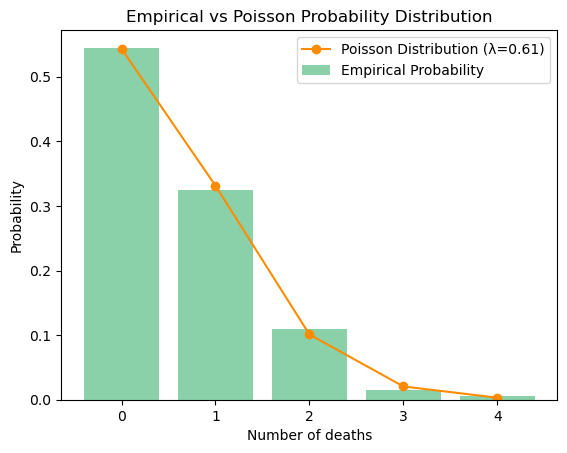

In [52]:
poisson_probs = poisson.pmf(x, mu=mu)

plt.bar(x, df['Probability'], color='mediumseagreen', alpha=0.6, label='Empirical Probability')
plt.plot(x, poisson_probs, 'o-', color='darkorange', label=f'Poisson Distribution (λ={mu:.2f})')
plt.xlabel('Number of deaths')
plt.ylabel('Probability')
plt.title('Empirical vs Poisson Probability Distribution')
plt.xticks(x)
plt.legend()
plt.show()